In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/news/bnlp_main.zip -d .

Archive:  /content/drive/MyDrive/news/bnlp_main.zip
   creating: ./bnlp_main/
   creating: ./bnlp_main/.github/
  inflating: ./bnlp_main/.github/stale.yml  
   creating: ./bnlp_main/.github/workflows/
  inflating: ./bnlp_main/.github/workflows/bnlp-publish-auto.yml  
  inflating: ./bnlp_main/.github/workflows/build_and_test.yml  
  inflating: ./bnlp_main/.gitignore  
  inflating: ./bnlp_main/.pre-commit-config.yaml  
   creating: ./bnlp_main/.vscode/
  inflating: ./bnlp_main/.vscode/settings.json  
   creating: ./bnlp_main/bnlp/
   creating: ./bnlp_main/bnlp/cleantext/
  inflating: ./bnlp_main/bnlp/cleantext/clean.py  
  inflating: ./bnlp_main/bnlp/cleantext/constants.py  
 extracting: ./bnlp_main/bnlp/cleantext/__init__.py  
   creating: ./bnlp_main/bnlp/corpus/
  inflating: ./bnlp_main/bnlp/corpus/corpus.py  
  inflating: ./bnlp_main/bnlp/corpus/_stopwords.py  
 extracting: ./bnlp_main/bnlp/corpus/__init__.py  
   creating: ./bnlp_main/bnlp/embedding/
  inflating: ./bnlp_main/bnlp/em

## English

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import pickle

In [3]:
data1 = pd.read_csv("drive/MyDrive/news/english/True.csv")
data2 = pd.read_csv("drive/MyDrive/news/english/Fake.csv")
data = pd.concat([data1, data2]).reset_index(drop=True)
data

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [4]:
y = [1 for i in range(data1.shape[0])] + [0 for i in range(data2.shape[0])]
y = pd.Series(y)
y

0        1
1        1
2        1
3        1
4        1
        ..
44893    0
44894    0
44895    0
44896    0
44897    0
Length: 44898, dtype: int64

In [5]:
def transform(c):
    return c["title"] + " " + c["text"]
data = data.apply(transform, axis=1)
data

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
44893    McPain: John McCain Furious That Iran Treated ...
44894    JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895    Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896    How to Blow $700 Million: Al Jazeera America F...
44897    10 U.S. Navy Sailors Held by Iranian Military ...
Length: 44898, dtype: object

Text Processing - Cleaning

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from nltk.tokenize import word_tokenize

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import string
punct = string.punctuation

In [8]:
def process(s):
    for p in punct:
        s = s.replace(p, '')
    s = s.lower()
    s = word_tokenize(s)
    s = [w for w in s if not w in stop_words] #optional
    s = [stemmer.stem(word) for word in s]
    return s

In [ ]:
number_of_samples = data.shape[0]

from tqdm import tqdm

for i in tqdm(range(number_of_samples)):
    data[i] = process(data[i])

In [ ]:
for i in tqdm(range(number_of_samples)):
    data[i] = " ".join(data[i])

100%|██████████| 44898/44898 [00:01<00:00, 44415.22it/s]


Text Representation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
eng_vec = CountVectorizer(max_features=5000)
bow_data = eng_vec.fit_transform(data).toarray()
features = eng_vec.get_feature_names_out()
bow_data = pd.DataFrame(bow_data, columns=features)

In [ ]:
pickle.dump(eng_vec,open("/content/drive/MyDrive/news/eng/eng_vec.p","wb"))

Training

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log")
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('MultinomialNB', nb), ('BernoulliNB', bnb), ('DecisionTreeClassifier', dt),
                                              ('SGDClassifier', sgd), ('RandomForestClassifier', rf)], voting='soft')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

xtrain, xtest, ytrain, ytest = train_test_split(bow_data, y, test_size=0.2)
model.fit(xtrain, ytrain)
ypred_ts = model.predict(xtest)
print("Testing Results:\n")
print(classification_report(ytest, ypred_ts, target_names=['FAKE', 'REAL']))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Testing Results:

              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      4743
        REAL       1.00      1.00      1.00      4237

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



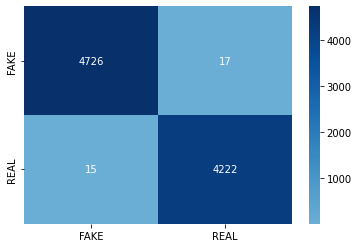

In [ ]:
CM = confusion_matrix(ytest,ypred_ts)
# drawing confusion matrix
target_names=['FAKE', 'REAL']
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.show()

In [ ]:

# Save the model as a pickle in a file
joblib.dump(model, '/content/drive/MyDrive/news/english/english.pkl')

['/content/drive/MyDrive/news/english/english.pkl']

Prediction

In [ ]:
tinput = 'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a â€œfiscal conservativeâ€ on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBSâ€™ â€œFace the Nation,â€ drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense â€œdiscretionaryâ€ spending on programs that support education, scientific research, infrastructure, public health and environmental protection. â€œThe (Trump) administration has already been willing to say: â€˜Weâ€™re going to increase non-defense discretionary spending ... by about 7 percent,â€™â€ Meadows, chairman of the small but influential House Freedom Caucus, said on the program. â€œNow, Democrats are saying thatâ€™s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I donâ€™t see where the rationale is. ... Eventually you run out of other peopleâ€™s money,â€ he said. Meadows was among Republicans who voted in late December for their partyâ€™s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. â€œItâ€™s interesting to hear Mark talk about fiscal responsibility,â€ Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. â€œThis is one of the least ... fiscally responsible bills weâ€™ve ever seen passed in the history of the House of Representatives. I think weâ€™re going to be paying for this for many, many years to come,â€ Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or â€œentitlement reform,â€ as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, â€œentitlementâ€ programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryanâ€™s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the â€œDreamers,â€ people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. â€œWe need to do DACA clean,â€ she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid.'
finput = 'Donald Trump Sends Out Embarrassing New Yearâ€™s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.'
input = process(finput)
input = " ".join(input)
input = eng_vec.transform([input]).toarray()
features = eng_vec.get_feature_names_out()
input = pd.DataFrame(input, columns=features)
weight_english = joblib.load("/content/drive/MyDrive/news/english/english.pkl")
pred = weight_english.predict(input)
if pred[0] == 1:
    print("Predicted news is True:")
else:
    print("Predicted news is Fake:")

Predicted news is Fake:


## Hindi

In [ ]:
import json
import pandas as pd
import re

with open('drive/MyDrive/news/hindi/fake_news-all.json') as f:
  fake_news = json.load(f)
  #json to dataframe
  fake_news = pd.json_normalize(fake_news,'fake_news')
  f.close()

with open('drive/MyDrive/news/hindi/true_news_all_dirty.json') as f:
  true_news = json.load(f)
  #json to dataframe
  true_news = pd.json_normalize(true_news,'true_news')
  f.close()

In [ ]:
true_news = true_news.rename(columns={'short_desc': 'short_description'})

In [ ]:
# dropping unncessary columns
true_news = true_news.drop(['full_title','long_description','name','url'],axis=1)
fake_news = fake_news.drop(['full_title', 'long_description', 'url'],axis=1)

In [ ]:
# removing null values
fake_news = fake_news.dropna()
true_news = true_news.dropna()

Text Processing - Cleaning

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def punct_re(true_news):
    for i in list(true_news):
        true_news[i]=true_news[i].str.replace('|', '')
        true_news[i]=true_news[i].str.replace('?', '')
        true_news[i]=true_news[i].str.replace(':', '')
        true_news[i]=true_news[i].str.replace(';', '')
        true_news[i]=true_news[i].str.replace("'", '')
        true_news[i]=true_news[i].str.replace('"', '')
        true_news[i]=true_news[i].str.replace(',', '')
        true_news[i]=true_news[i].str.replace('.', '')
        true_news[i]=true_news[i].str.replace('(', '')
        true_news[i]=true_news[i].str.replace(')', '')
        true_news[i]=true_news[i].str.replace('\n', '')
        true_news[i]=true_news[i].str.replace('&', '')
    return true_news

In [ ]:
true_news = punct_re(true_news)
fake_news = punct_re(fake_news)

In [ ]:
fake_news

,short_description
0,बूम ने पाया कि इमरान खान भारत सरकार की आलोचना ...
1,सिख समुदाय के कुछ लोगों को हिंदी साइन बोर्ड पर...
2,सोशल मीडिया प्लेटफ़ॉर्म फ़ेसबुक और ट्विटर पर इस ...
3,दावा है कि भाजपा के नेताओं ने माना है कि सरकार...
4,मीडिया आउटलेट्स और वायर एजेंसी ने गलत तरीके से...
...,...
1245,भारतीय पहलवान कविता देवी और बुल बुल के बीच हुए...
1246,बूम से बात करते हुए एसबीआई अधिकारी ने बताया कि...
1247,बीजेपी सांसद परेश रावल एक बार फिर अपने फेक न्य...
1248,मार्च से लेकर मई महीने में अचानक से एक्टिव हुई...


Stemming

In [ ]:
suffixes = {
    1: ["ो", "े", "ू", "ु", "ी", "ि", "ा"],
    2: ["कर", "ाओ", "िए", "ाई", "ाए", "ने", "नी", "ना", "ते", "ीं", "ती", "ता", "ाँ", "ां", "ों", "ें"],
    3: ["ाकर", "ाइए", "ाईं", "ाया", "ेगी", "ेगा", "ोगी", "ोगे", "ाने", "ाना", "ाते", "ाती", "ाता", "तीं", "ाओं", "ाएं", "ुओं", "ुएं", "ुआं"],
    4: ["ाएगी", "ाएगा", "ाओगी", "ाओगे", "एंगी", "ेंगी", "एंगे", "ेंगे", "ूंगी", "ूंगा", "ातीं", "नाओं", "नाएं", "ताओं", "ताएं", "ियाँ", "ियों", "ियां"],
    5: ["ाएंगी", "ाएंगे", "ाऊंगी", "ाऊंगा", "ाइयाँ", "ाइयों", "ाइयां"],
}

def hi_stem(word):
    for L in 5, 4, 3, 2, 1:
        if len(word) > L + 1:
            for suf in suffixes[L]:
                if word.endswith(suf):
                    return word[:-L]
    return word

In [ ]:
id=list(fake_news.index)
id1=list(true_news.index)

In [ ]:
str_temp=""
count=0
for i in list(fake_news):
  count=0
  for j in list(fake_news[i]):
    for words in j.split():
      str_temp+=hi_stem(words)
      str_temp+=" "
    fake_news.loc[id[count],i]=str_temp
    str_temp=""
    count+=1

In [ ]:
str_temp=""
count=0
for i in list(true_news):
  count=0
  for j in list(true_news[i]):
    for words in j.split():
      str_temp+=hi_stem(words)
      str_temp+=" "
    true_news.loc[id1[count],i]=str_temp
    str_temp=""
    count+=1

Stop words removal

In [ ]:
stop=open('drive/MyDrive/news/hindi/final_stopwords.txt')
stopwords=[]
for x in stop:
  x = x.replace('\n', '')
  stopwords.append(x)

In [ ]:
from numpy import unicode
str_temp=""
count=0
for i in list(fake_news):
  count=0
  for j in list(fake_news[i]):
    for words in j.split():
      if unicode(words) not in stopwords:
        str_temp+=words
        str_temp+=" "
    fake_news.loc[id[count],i]=str_temp
    str_temp=""
    count+=1

In [ ]:
from numpy import unicode
str_temp=""
count=0
for i in list(true_news):
  count=0
  for j in list(true_news[i]):
    for words in j.split():
      if unicode(words) not in stopwords:
        str_temp+=words
        str_temp+=" "
    true_news.loc[id1[count],i]=str_temp
    str_temp=""
    count+=1

In [ ]:
# make both length equal
if len(fake_news) > len(true_news):
  fake_news = fake_news.head(len(true_news))
elif len(true_news) > len(fake_news):
  true_news = true_news.head(len(fake_news))
print("Length of fake news: ", len(fake_news))
print("Length of true news: ", len(true_news))

Length of fake news:  760
Length of true news:  760


In [ ]:
true_news['label']=1
fake_news['label']=0
news = pd.concat([fake_news, true_news])
news

In [ ]:
true_news.loc[0].tolist()

['भारत ऑस्ट्रेलिय टेस्ट सिरीज़ ऐतिहासिक जीत दर्ज चौथ निर्णायक मैच नौजवान गेंदबाज़ मोहम्मद सिराज अहम भूमिक निभ ',
 1]

In [ ]:
news

,short_description,label
0,बूम पाय इमरान खान भारत सरकार आलोच रह वर्तमान श...,0
1,सिख समुदाय के लोग हिंद साइन बोर्ड कालिख पोत दि...,0
2,सोशल मीडिय प्लेटफ़ॉर्म फ़ेसबुक ट्विटर दाव के बड़ ...,0
3,दाव भाजप के मा सरकार जन के गलत रह ।,0
4,मीडिय आउटलेट्स वायर एजेंस गलत तरीक दाव किय पाक...,0
...,...,...
887,चालक कार रोक के बजाय चल जार रख ट्रैफ़िक पुलिसक...,1
888,मिसाइल 400 किलोमीटर ज़्याद मार सक,1
889,आकर्षण केंद्र वो शक्तिशाल पहलवान जिनक संबंध प्...,1
890,बिहार के जातिगत समीकरण बात लंब बीजेप हिंद पहचा...,1


In [ ]:
news.loc[1].values

array([['सिख समुदाय के लोग हिंद साइन बोर्ड कालिख पोत दिख तस्वीर सेट वीडिय वायरल रह ',
        0],
       ['ब्रिस्बेन टेस्ट भारत दीवार कह वाल चेतेश्वर पुजार अर्धशतक जम पार के वो चोटिल ऑस्ट्रेलिय गेंदबाज़ गेंद उनक शरीर लग ',
        1]], dtype=object)

In [ ]:
news.loc[0].tolist()

Text Representation

In [ ]:
X = news.iloc[:, 0]
y = news.iloc[:, 1]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
hin_vec = CountVectorizer(max_features=5000)
bow_data = hin_vec.fit_transform(X).toarray()
features = hin_vec.get_feature_names_out()
bow_data = pd.DataFrame(bow_data, columns=features)

In [ ]:
pickle.dump(hin_vec,open("/content/drive/MyDrive/news/hindi/hind_vec.p","wb"))

In [ ]:
bow_data

,10,100,10000,104,107,108,10व,11,110,116,...,ज़र,ज़फ़,ड़छ,ड़फ,फ़त,फ़य,फ़र,फ़रनगर,फ़रवर,फ़हद
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Training

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log")
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('MultinomialNB', nb), ('BernoulliNB', bnb), ('DecisionTreeClassifier', dt),
                                              ('SGDClassifier', sgd), ('RandomForestClassifier', rf)], voting='soft')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

xtrain, xtest, ytrain, ytest = train_test_split(bow_data, y, test_size=0.2)
model.fit(xtrain, ytrain)
ypred_ts = model.predict(xtest)
print("Testing Results:\n")
print(classification_report(ytest, ypred_ts, target_names=['FAKE', 'REAL']))

Testing Results:

              precision    recall  f1-score   support

        FAKE       0.90      0.86      0.88       160
        REAL       0.85      0.89      0.87       144

    accuracy                           0.87       304
   macro avg       0.87      0.87      0.87       304
weighted avg       0.87      0.87      0.87       304



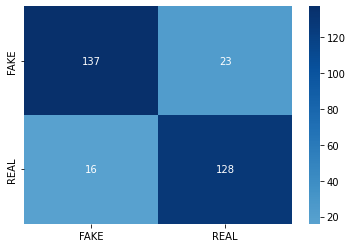

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['FAKE', 'REAL']
CM = confusion_matrix(ytest,ypred_ts)
# drawing confusion matrix
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.show()

In [ ]:
import joblib
# Save the model as a pickle in a file
joblib.dump(model, '/content/drive/MyDrive/news/hindi/hindi.pkl')

['/content/drive/MyDrive/news/hindi/hindi.pkl']

Prediction

In [ ]:
finput = 'बूम पाय इमरान खान भारत सरकार आलोच रह वर्तमान शासन अधिनायकवाद मुस्लिम विरोध पाकिस्तान'
input = hin_vec.transform([finput]).toarray()
features = hin_vec.get_feature_names_out()
input = pd.DataFrame(input, columns=features)
weight_hindi = joblib.load("/content/drive/MyDrive/news/hindi/hindi.pkl")
pred = model.predict(input)
if pred[0] == 1:
    print('Predicted news is REAL')
else:
    print('Predicted  news is FAKE')

Predicted news is REAL


## Bengali

In [10]:
!pip install bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=6a6062548fceb898acf1133a5cc9d96eca36327d3672d38ba9a8f59e86b859c1
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
auth = pd.read_csv("drive/MyDrive/news/bengali/Authentic-48K.csv")
fake = pd.read_csv("drive/MyDrive/news/bengali/Fake-1K.csv")

In [ ]:
df = auth[:fake.shape[0]]
df = df.append(fake)
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df

,articleID,domain,date,category,headline,content,label
0,216,bangla.thereport24.com,2018-09-20 12:29:26,International,মালয়েশিয়ায় মদ পানে বাংলাদেশিসহ ১৫ জনের মৃত্যু,দ্য রিপোর্ট ডেস্ক : মালেশিয়ায় মদপানে এক বাংলাদ...,1
1,364,channeldhaka.news,2018-11-13T16:18:10+00:00,Sports,বিয়ের পর আমার অনেক বেশি উন্নতি হয়েছে: মুশফিক,সোমবার ঢাকা টেস্টে জিম্বাবুয়ের বিপক্ষে ক্যারি...,0
2,969,motikontho.wordpress.com,2012-12-30T16:15:22+00:00,Miscellaneous,আসিফ নজরুল একটি বান্দর: আল্লামা সাঈদী | দৈনিক ...,কারাগার মতিবেদকমেশিনের দৈর্ঘ নিয়ে সন্দেহ প্রক...,0
3,929,channeldhaka.news,2019-01-10T03:39:06+00:00,National,বরিশাল হতে যাচ্ছে দ্বিতীয় সিঙ্গাপুর,বরিশালই হতে যাচ্ছে দ্বিতীয় সিঙ্গাপুর! উন্নয়ন...,0
4,1177,motikontho.wordpress.com,2014-10-29T12:17:40+00:00,National,আছিলাম কুকুর হইলাম লেজ: মেডাম | দৈনিক মতিকণ্ঠ,নিজস্ব মতিবেদকআন্তর্জাতিক অপরাধ ট্রাইবুনাল কতৃ...,0
...,...,...,...,...,...,...,...
2593,1125,earki.com,"সেম্বর ১৮, ২০১৮",Miscellaneous,ডাক্তারি জগতে এবার এলো নতুন প্রেসক্রিপশন 'নৌকা...,"যুগ, প্রযুক্তি এবং মেডিকেলশাস্ত্রের উন্নয়নের স...",0
2594,278,jugantor.com,2018-09-20 05:52:43,Editorial,হাবিব-উন নবী সোহেল গ্রেফতার,বিএনপির যুগ্ম মহাসচিব ও ঢাকা মহানগর দক্ষিণের স...,1
2595,443,samakal.com,2018-09-19 18:36:34,National,শিক্ষার্থীদের অনুরোধে গান গাইলেন প্রতিমন্ত্রী,﻿তথ্য ও যোগাযোগ প্রযুক্তি প্রতিমন্ত্রী জুনাইদ ...,1
2596,575,bengali.oneindia.com,2019-03-9 20:14:10,Entertainment,হতাশ জুকারবার্গ! সত্যি সত্যি কি ফেসবুক 'ডিলিট'...,ফেসবুকের তথ্য ফাঁস কেলেঙ্কারিতে মুখ খুললেন মার...,0


Preprocessing

In [11]:
from bnlp import BasicTokenizer
from bnlp_main.bnlp.corpus.corpus import BengaliCorpus

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in BengaliCorpus.stopwords:
            continue

        if i in BengaliCorpus.punctuations + '‘' + '’':
            continue

        filtered.append(i)

    return " ".join(filtered)


punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df['headline'] = df.headline.apply(clean_text)
df['content'] = df.content.apply(clean_text)

In [ ]:
df

,articleID,domain,date,category,headline,content,label
0,216,bangla.thereport24.com,2018-09-20 12:29:26,International,মালয়েশিয়ায় মদ পানে বাংলাদেশিসহ ১৫ মৃত্যু,দ্য রিপোর্ট ডেস্ক মালেশিয়ায় মদপানে এক বাংলাদেশ...,1
1,364,channeldhaka.news,2018-11-13T16:18:10+00:00,Sports,বিয়ের উন্নতি মুশফিক,সোমবার ঢাকা টেস্টে জিম্বাবুয়ের বিপক্ষে ক্যারি...,0
2,969,motikontho.wordpress.com,2012-12-30T16:15:22+00:00,Miscellaneous,আসিফ নজরুল বান্দর আল্লামা সাঈদী দৈনিক মতিকণ্ঠ,কারাগার মতিবেদকমেশিনের দৈর্ঘ সন্দেহ প্রকাশ বৃহ...,0
3,929,channeldhaka.news,2019-01-10T03:39:06+00:00,National,বরিশাল দ্বিতীয় সিঙ্গাপুর,বরিশালই দ্বিতীয় সিঙ্গাপুর উন্নয়নের ধারা অব্য...,0
4,1177,motikontho.wordpress.com,2014-10-29T12:17:40+00:00,National,আছিলাম কুকুর হইলাম লেজ মেডাম দৈনিক মতিকণ্ঠ,নিজস্ব মতিবেদকআন্তর্জাতিক অপরাধ ট্রাইবুনাল কতৃ...,0
...,...,...,...,...,...,...,...
2593,1125,earki.com,"সেম্বর ১৮, ২০১৮",Miscellaneous,ডাক্তারি জগতে এলো প্রেসক্রিপশন নৌকা বেলা,যুগ প্রযুক্তি মেডিকেলশাস্ত্রের উন্নয়নের ডাক্তা...,0
2594,278,jugantor.com,2018-09-20 05:52:43,Editorial,হাবিব উন নবী সোহেল গ্রেফতার,বিএনপির যুগ্ম মহাসচিব ঢাকা মহানগর দক্ষিণের সভা...,1
2595,443,samakal.com,2018-09-19 18:36:34,National,শিক্ষার্থীদের অনুরোধে গান গাইলেন প্রতিমন্ত্রী,﻿তথ্য যোগাযোগ প্রযুক্তি প্রতিমন্ত্রী জুনাইদ আহ...,1
2596,575,bengali.oneindia.com,2019-03-9 20:14:10,Entertainment,হতাশ জুকারবার্গ সত্যি সত্যি ফেসবুক ডিলিট তথ্য ...,ফেসবুকের তথ্য ফাঁস কেলেঙ্কারিতে মুখ খুললেন মার...,0


In [ ]:
# dropping unncessary columns
df = df.drop(['articleID','domain','date','category'],axis=1)

Text Representation

In [ ]:
X = df.iloc[:, 1]
y = df.iloc[:, 2]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
ben_vectorizer = CountVectorizer(max_features=5000)
bow_data = ben_vectorizer.fit_transform(X).toarray()
features = ben_vectorizer.get_feature_names_out()
bow_data = pd.DataFrame(bow_data, columns=features)

In [ ]:
# pickle.dump(ben_vectorizer,open("/content/drive/MyDrive/news/bengali/bengali_vec.p","wb"))

In [ ]:
bow_data

,2018,24,24sharetweet,3d,500,7777,abbey,abul,ac,account,...,৯৮,৯৮ট,৯৮৭,৯৯,৯৯৫,৯৯৯,৷গ,৷তব,৷দ,৷ব
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Training

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log")
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('MultinomialNB', nb), ('BernoulliNB', bnb), ('DecisionTreeClassifier', dt),
                                              ('SGDClassifier', sgd), ('RandomForestClassifier', rf)], voting='soft')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

xtrain, xtest, ytrain, ytest = train_test_split(bow_data, y, test_size=0.2)
model.fit(xtrain, ytrain)
ypred_ts = model.predict(xtest)
print("Testing Results:\n")
print(classification_report(ytest, ypred_ts, target_names=['FAKE', 'REAL']))

Testing Results:

              precision    recall  f1-score   support

        FAKE       0.93      0.93      0.93       259
        REAL       0.93      0.93      0.93       261

    accuracy                           0.93       520
   macro avg       0.93      0.93      0.93       520
weighted avg       0.93      0.93      0.93       520



confusion matrix

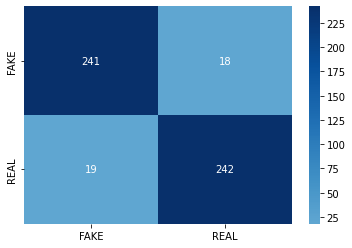

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['FAKE', 'REAL']
CM = confusion_matrix(ytest,ypred_ts)
# drawing confusion matrix
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.show()

In [ ]:
import joblib
# Save the model as a pickle in a file
joblib.dump(model, '/content/drive/MyDrive/news/bengali/bangla.pkl')

['/content/drive/MyDrive/news/bengali/bangla.pkl']

Prediction

In [23]:
tinput = 'আন্তর্জাতিক ডেস্ক আরটিএনএন কোপেহেগেন মসজিদের নিচের তলায় প্রবেশাধিকার সংরক্ষণ ইমামদের চুপচাপ থাকার নির্দেশ মূল ফটক দিয়ে প্রবেশে বাঁধা প্রাপ্ত হওয়া কারণে মুসলিম নারীরা মসজিদে পুরুষদের শাসিত হয়ে ধারণা বাস্তবতার প্রেক্ষিতে ডেনমার্কের কোপেনহেগন যুক্তরাষ্ট্রের লস এঞ্জেলস শহরে ইতিমধ্যেই গড়ে ওঠেছে শুধুমাত্র মুসলিম নারীদের ইবাদত মসজিদ বর্তমানে মুসলিম নারীরা উপাসনালয়ের অধিকার সোচ্চার ইতিহাস জুড়ে পুরুষ পরিচালিত হয়েছিলো ইউরোপে মুসলিম নারীদের মসজিদের প্রতিষ্ঠাতা শেরিন খানকান বার্তা সংস্থা রয়টার্সকে জানান দশকের দশকে পুরুষতান্ত্রিক মনোভাব গড়ে উঠেছে পাল্টানো সম্ভব ডেনমার্কের ব্যস্ততম বাজারে রাস্তার পাশেই মসজিদ গড়ে তুলেছেন সচরাচর চোখে পড়ে মসজিদটি নারীদের এরকম উদ্যোগে সৃষ্টির নীরবে বিপ্লব ঘটিয়ে চলেছে গত বছর ধরেই মসজিদটিতে নারী ইমাম নামাজে নেতৃত্ব দিয়ে আসছেন খানকান কুরআনের শিক্ষার বিরুদ্ধে পুরুষতান্ত্রিক মনোভাব পাল্টাতে নতুনভাবে চাই লিঙ্গ বৈষম্য দূর চাই সংস্কার ইসলামের মূল শিক্ষার চাই শেরিন খানকান এমনটি শেরিন খানকান আরো মসজিদে ১৫০ ইবাদতকারী নিয়মিত ইবাদত আসেন ডেনমার্কের মুসলিম নারী ধর্মীয় নেতৃবৃন্দের নিকট সহযোগিতা পেয়েছেন বলেও উল্লেখ নারীদের নিবেদিত স্থান মুসলিম নারীদের সংগঠন জানিয়েছে বর্তমান বিশ্বে নারী ইসলামী নেতৃত্বের বড়ই অভাব দেশের বেশীরভাগ মসজিদগুলো পুরুষদের নিয়ন্ত্রিত মুসলিম নারীদের মসজিদে প্রার্থনা করাটা কঠিন হয়ে দাঁড়ায় গত ১৫ বছর প্রচেষ্টার ফলাফল স্বরূপ শেরিন খানকানের মারিয়াম মসজিদই যুক্তরাষ্ট্রের লস এঞ্জেলস শহর জার্মানির বার্লিনে দুইটি মসজিদ প্রতিষ্ঠা হয়েছে শুক্রবার নারী পুরুষদের মসজিদে একত্রে নামায আদায় সুযোগ দিচ্ছে এমনকি যুক্তরাজ্যের ব্রেডফ্রোড শহরে দেশটির নারী নেতৃত্বাধীন মসজিদ প্রতিষ্ঠা ২০২০ সালের সম্পন্ন ধারণা জেনে দরকার চীনে শত বছর ধরেই শুধুমাত্র মুসলিম নারীদের আলাদা মসজিদ রয়েছে ঐতিহ্যগতভাবে মুসলিম নারীরা নেতৃত্ব দিয়ে যুক্তরাজ্যের ব্রেডফ্রোড শহরের মসজিদ প্রতিষ্ঠার অন্যতম উদ্যোক্তা বানা গোরা ব্রিটেন মুসলিম ওমেন স কাউন্সিলের পরিচালক সমাজে বিদ্যমান সমস্যাগুলো মুসলিম নারীরা অন্যের সাথে মত প্রকাশ কোথায় দরকার নিবেদিত স্থান মুসলিম নারীরা মত প্রকাশ পারবে কোথায়ও এরকম স্থান পাইনা আরো সেজন্যই নারীরা মসজিদে স্থান দেয়ার দাবী জানাচ্ছে এটাতে ভুল দেখছি নারীদের অন্তরীণ হয়েছে শেরিন খানকান মসজিদে নারীদের উপস্থিতি তাদেরকে অধিকার প্রতিষ্ঠিত হয়েছে অনুভূতি দেয় মসজিদে গুরুত্বপূর্ণ সমস্যার সমাধান আন্ত ধর্মীয় বিবাহ গৃহ সংঘাত আরো ডেনমার্কে বোরকা নিষিদ্ধ কারণে মুসলিম নারীদের নিরাপদ পৃথিবী সংকুচিত হয়ে ফ্রান্সসহ অন্যান্য ইউরোপীয় দেশের সাথে তাল মিলিয়ে ডেনমার্কের আইনসভা চলতি বছরের মে মাসে বোরকার নিষেধাজ্ঞা আরোপ দেশটির বিচার মন্ত্রী বোরকা নিষিদ্ধ ডেনমার্কের নারীদেরকে পরিবারের জোর চাপিয়ে দেয়া সিদ্ধান্ত মুক্তি দিয়েছেন দাবী শেরিন খানকান নারীদেরকে জোর বোরকা পরিধান করানো তাদেরকে অন্তরীণ সামিল অবশ্যই শুভ বিষয় বোরকা পরিধানকারীদের অপরাধীদের সাথে তুলনা নারীদেরকে আরো বেশী অন্তরীণ সামিল ইসলামের ভবিষ্যৎ শেরিন খানকান আশা ভবিষ্যতে মুসলিম নারীদের মধ্য ইসলামী বিশেষজ্ঞ ইমাম উঠে আসবেন মুসলিম নারীদের অধিকার প্রতিষ্ঠায় গুরুত্বপূর্ণ ভূমিকা রাখবেন দরকার নারীরাই ইসলামের ভবিষ্যৎ অবশ্যই নারীদের পুরুষদের মত সমান সুযোগ সৃষ্টি প্রসঙ্গত বেশীরভাগ ইসলামী বিশেষজ্ঞের মতে পবিত্র কুরআনে নারীদের নামাজে ইমামতি সরাসরি হয়নি বিশেষজ্ঞ নবী মুহাম্মদ সাঃ নারীদেরকে ইমামতি অনুমতি দিয়েছেন অন্যদিকে বেশীরভাগ বিশেষজ্ঞ নবী মুহাম্মদ সাঃ নারীদেরকে শুধুমাত্র গৃহে ইবাদত নির্দেশ দিয়েছেন এখনো ঐতিহ্যগত ইসলামী বিশেষজ্ঞ নারীরা নামায রত পুরুষদের কণ্ঠস্বর শোনা এডিনবার্গ বিশ্ববিদ্যালয়ের গিউলিয়া লিবারেটর নামের একজন অধ্যাপক মুসলিম নারী বিশেষজ্ঞদের গবেষণারত আছেন মুসলিম নারীদেরকে ক্ষমতা দেয়া প্রভাব ইতিবাচক নারীরা নারীদেরকে উচ্চ আসনে দেখবে ধারণা জন্মাবে তারাও একজন বিশেষজ্ঞ পারবেন গিউলিয়া লিবারেটর এমনটি জানান সূত্রঃ স্ক্রল ডট ইন'
finput = 'পরিচিত কারো সাথে ডাক্তার মেয়ে বিয়ে দিয়েন পলাশ ভাই আমারে দেখেন ডাক্তার মেয়ে বিয়ে এক বিপদে আছি বিয়ের রাতে বাসর ঘরে ঢুকার পুরাই বেকুব বউয়ের কিসের ঘোমটা কিসের দেখি টেবিলে মোটা মোটা তিনটা বই বড়ো বড়ো চোখ পড়তাছে আমারে তিনদিন পরীক্ষা বিয়ের ঝামেলায় পড়তে ঠিকমতো আজকে সারারাত পরলে ফেইল সারারাত পড়ছে তাইলে মাঝখানে ভদ্রতা জিজ্জাসা করছি লাগবে ভদ্রতা গিয়া আরেক বিপদ আমারে এক ফ্লাস্ক চা এতো রাইতে চা পাই কই রাত তিনটায় শেরওয়ানি পড়ে কিচেনে ঢুকছি চা বানাইতে আল্লাহ্ বাঁচাইছে পরীক্ষার হয়ে আরো খারাপ হইছে পরীক্ষার পরই হইছে ইন্টার্নি রাতে ডিউটি যাও রাতে পাইতাম গেলো সারারাত ডিউটি দিয়া বাসায় আসার সারাদিন নাক ডাকাইয়া ভুস ভুস শব্দ কইরা ঘুমাইতো তাইলে রোমান্টিকতা পারো করছিলাম গভীর রাতে এসএমএস দিছি তোমারে পাইতে ইচ্ছা করতাছে বউ রিপ্লাই দিছে হাসপাতালে চইল্যা আসো করলা করমু একটা রিলাক্সিন খাইয়া শরীর রিলাক্স কইরা ঘুমাইয়া গেছি বউ ডাক্তার হওয়াতে একটা সুবিধা হইছে কখন ঔষধ খাইতে হইবো মোটামুটি শেষ একটা ছেলে হইছে কেমন হইছে মহাত্মা গান্ধীর পলাশ ভাই মহাত্মা গান্ধীরে প্যাম্পার পড়াইলে দেখাইবো লাগে ভালো কথা ভাবি ডাক্তার ডাক্তারি পড়ার শখ ছিলো কারণে পড়া আল্লাহ্ বড় বাঁচাইছে পলাশ ভাই ভাবিরে – আপনারে'
input = clean_text(tinput)
ben_vectorizer  = pickle.load(open("/content/drive/MyDrive/news/bengali/ben_vectorizer.p","rb"))
bow_data = ben_vectorizer.transform([input]).toarray()
features = ben_vectorizer.get_feature_names_out()
bow_data = pd.DataFrame(bow_data, columns=features)
weight_bengali = joblib.load('/content/drive/MyDrive/news/bengali/bangla.pkl')
pred = weight_bengali.predict(bow_data)
if pred[0] == 1:
    print('REAL')
else:
    print('FAKE')

REAL


## Web

In [4]:
!pip install pyngrok==5.2.1
!pip install langdetect
!pip install flask-ngrok
!ngrok authtoken 24jMmkCh5Tr4hOZ9Dpg69QtTDSH_3n21SSxtBHr1F9QckcBzi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19772 sha256=986a466aecfba826bf7fae940ac0254f95bda3d68db2dc3a16fd1aafe0738771
  Stored in directory: /root/.cache/pip/wheels/6c/e1/46/8d60711cb43fb2e055fb69bb9964f91c9a5046f7924d2996ac
Successfully built pyngrok
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=29f3d68ac173d025a099298dc17fd5801f293f4e337d2f69bd374a197c79955c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [5]:
import collections
collections.Iterable = collections.abc.Iterable

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import app,request, render_template
import json
import sys
from flask import jsonify
# import requests
from datetime import datetime
from base64 import b64decode
from langdetect import detect

app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run
@app.route('/')
def index():
    return render_template("index.html")

@app.route('/',methods=['POST'])
def pre():
    if request.method == 'POST':
        txt = request.form['txt']
        lang = detect(str(txt))
        if lang == 'en':
            txt = str(txt)
            txt = process(txt)
            txt = " ".join(txt)
            eng_vec = pickle.load(open('/content/drive/MyDrive/news/english/eng_vec.pkl', 'rb'))
            txt = eng_vec.transform([txt]).toarray()
            features = eng_vec.get_feature_names_out()
            txt = pd.DataFrame(txt, columns=features)
            model = joblib.load('/content/drive/MyDrive/news/english/english.pkl')
            pred = model.predict(txt)
            # print(pred)
            return render_template("index.html", result = pred[0])
        elif lang== 'bn':
            txt = clean_text(txt)
            ben_vectorizer  = pickle.load(open("/content/drive/MyDrive/news/bengali/ben_vectorizer.p","rb"))
            bow_data = ben_vectorizer.transform([txt]).toarray()
            features = ben_vectorizer.get_feature_names_out()
            bow_data = pd.DataFrame(bow_data, columns=features)
            model = joblib.load('/content/drive/MyDrive/news/bengali/bangla.pkl')
            pred = model.predict(bow_data)
            return render_template("index.html", result = pred[0])
        elif lang == 'hi':
            hin_vec = pickle.load(open("/content/drive/MyDrive/news/hindi/hind_vec.p","rb"))
            bow_data = hin_vec.transform([txt]).toarray()
            features = hin_vec.get_feature_names_out()
            bow_data = pd.DataFrame(bow_data, columns=features)
            model = joblib.load('/content/drive/MyDrive/news/hindi/hindi.pkl')
            pred = model.predict(bow_data)
            return render_template("index.html", result = pred[0])

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://0a9c-104-196-196-13.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [13/Jan/2024 11:20:27] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jan/2024 11:20:28] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [13/Jan/2024 11:20:37] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jan/2024 11:20:59] "POST / HTTP/1.1" 200 -
